In [1]:
using Gurobi, JuMP   #JuMP是一个优化库(可以在里面插入优化的库，比如Gurobi) Import everything 
using DataFrames, GLM
using Plots
using Distributions
using Random
using LinearAlgebra
using DelimitedFiles

In [2]:
#rand-均匀分布； randn-正态分布
#Function for simulating data
function Data(n,m,a,b,c,r,s,form="flat",seed=1)
	Random.seed!(seed)   #Random: Support for generating random numbers.   Random.rand!-Function是的，(seed)可以将随机数固定
	#Drawing random decision data
	x = rand(n)  #x是[0,1]之间的随机数，所以我们产生的data points是随机的
	#Drawing random outcome data
	y,y_min,y_max = Outcome(x,a,b,c,r,s,form)
	#Setting all possible values for decisions
    d = collect(0.1:1/m:0.9)
	return x,y,y_min,y_max,d
end

#Function for simulating outcome. 拟合各种函数结果
function Outcome(x,a,b,c,r,s,form="flat")
	n = length(x)
    y = zeros(n)
    #Simulating the random outcome for each random decision
    for i = 1:n
        if form == "flat"
            y[i] = a + s*randn()[1]
        elseif form == "flat-double"
            y[i] = a + s*randn()[1]
            if 0.5 <= x[i] <= 0.75
                y[i] = r*a + s*randn()[1]   #这里有随机项，所以对于相同的x值，y值也有很小的差别
            end
        elseif form == "linear"
            y[i] = a + b*x[i] + s*randn()[1]
        elseif form == "linear-double"
            y[i] = a + b*x[i] + s*randn()[1]
            if 0.5 <= x[i]
                y[i] = r*a + a*(1-r)*x[i] + s*randn()[1]
            end
        elseif form == "quadratic"
            y[i] = a + b*x[i] + c*x[i]^2 + s*randn()[1]
        elseif form == "quadratic-double"
            y[i] = a + b*x[i] + c*x[i]^2 + s*randn()[1]   #此处需要数字而不是数组，故需要将randn() 转化为randn()[1]
            if 0.5 <= x[i]
                y[i] = r*a + (3*a*(1-r)+2*b+c)*x[i] + (-2*a*(1-r)-2*b-c)*x[i]^2 + s*randn()[1]    #r具体是多少？如何使得函数在边界点处相等？可以用公式计算出r的表达式
            end
        elseif form == "newsvendor"
        	demand = a + s*randn()[1]
        	y[i] = -(c*x[i] + r*b*max(demand-x[i],0) + b*max(x[i]-demand,0))
        elseif form == "supplychain-normal"
        	y[i] = x[i] * (quantile(Normal(c,r),(a-x[i])/(a+b))) + s*randn()[1]
        elseif form == "supplychain-pareto"
        	y[i] = x[i] * (quantile(Pareto(c,r),(a-x[i])/(a+b))) + s*randn()[1]
        end		       
    end
    #Scaling the outcome to unit scale
    y_min = minimum(y)
    y_max = maximum(y)
    y = (y - ones(n)*y_min)./(ones(n)*(y_max-y_min))   #将y归一化
	return y,y_min,y_max
end


Outcome (generic function with 2 methods)

In [16]:
#Function for computing result  
function Result(y_min,y_max,x,a,b,c,r,form="flat")
	#Computing the expected outcome for given decision
    if form == "flat"
        y = a
    elseif form == "flat-double"
        y = a
        if 0.5 <= x <= 0.75
            y = r*a               ### What is the value of r??????
        end
    elseif form == "linear"
        y = a + b*x
    elseif form == "linear-double"
        y = a + b*x
        if 0.5 <= x
            y = r*a + a*(1-r)*x
        end
    elseif form == "quadratic"
        y = a + b*x + c*x^2
    elseif form == "quadratic-double"
        y = a + b*x + c*x^2
        if 0.5 <= x
            y = r*a + (3*a*(1-r)+2*b+c)*x + (-2*a*(1-r)-2*b-c)*x^2
        end
    elseif form == "newsvendor"
    	demand = a
    	y = -(c*x + r*b*max(demand-x,0) + b*max(x-demand,0))
    elseif form == "supplychain-normal"
        y = x * (quantile(Normal(c,r),(a-x)/(a+b)))
    elseif form == "supplychain-pareto"
        y = x * (quantile(Pareto(c,r),(a-x)/(a+b)))
    end
    #Scaling the outcome to unit scale
    y = (y-y_min)/(y_max-y_min)
	return y
end

Result (generic function with 2 methods)

In [17]:
#Function for jointly estimating and optimizing
function EWO(x,y,d,kappa,lambda,M,showoutput=false)
    n = length(x)
    m = length(d)
    #Defining optimization model
	model = Model()
	set_optimizer(model, Gurobi.Optimizer)      #调用Gurobi里面的optimizer? Yep
	set_optimizer_attributes(model, "OutputFlag" => 0)   #??????  This arrow means equal to zero
    #Defining variables
    @variable(model, a)     ### 定义变量语法（general way）
    @variable(model, b)
    @variable(model, u[1:n], Bin)   #u[1:n]都是binary variable
    @variable(model, v[1:n], Bin)
    @variable(model, w[1:n], Bin)
    @variable(model, z[1:m], Bin)
    @variable(model, s[1:m] >= 0)
    @variable(model, t[1:n] >= 0)
	#Defining objective
    @objective(model, Max, sum(s[j] for j=1:m) - lambda * sum(t[i] for i=1:n))
    #Defining constraints
    @constraints(model, begin
        decision, sum(z[j] for j=1:m) == 1   #decision here is the name of the constraint
        revenue_passive[j=1:m], s[j] <= a+b*d[j]
        revenue_active[j=1:m], s[j] <= M*z[j]
        data[i=1:n], u[i] >= v[i] + w[i] - 1
        data_upper[i=1:n], x[i] - sum(d[j]*z[j] for j=1:m) >= kappa - M*v[i]   ### Meaning of this constraints? It's a linear programming problem, but the equivalents are hard to write
        data_lower[i=1:n], sum(d[j]*z[j] for j=1:m) - x[i] >= kappa - M*w[i]
        estimation_upper[i=1:n], t[i] >= y[i]-a-b*x[i]-M*(1-u[i])
        estimation_lower[i=1:n], t[i] >= -y[i]+a+b*x[i]-M*(1-u[i])
    end)
    #Optimizing model
    optimize!(model)
    obj_val = objective_value(model)
    time_val = solve_time(model)
    a_val = value.(a)
    b_val = value.(b)
    z_val = value.(z)
    return obj_val,time_val,a_val,b_val,z_val
end

EWO (generic function with 2 methods)

In [18]:
#Selecting setup
#setup = ["flat-double",100,0,0,4,1,0.05,1]
setup = ["linear-double",100,100,0,0.75,1,0.05,1]
#setup = ["quadratic-double",100,100,-100,0.5,1,0.05,0.1]
#setup = ["newsvendor",0.5,4,1,0.75,0.1,0.05,0.1]
#setup = ["supplychain-normal",1,1,4,3,0.1,0.05,0.1]
#setup = ["supplychain-pareto",1,1.5,0.25,1,0.1,0.05,0.1]

#Setting parameters    
form_data = setup[1]
alpha = setup[2]
beta = setup[3]
gamma = setup[4]
rho = setup[5]
sigma = setup[6]   #相当于前面的s
kappa = setup[7]
lambda = setup[8]
n = 1000
m = 100
big_M = 1000
seed_numbers = 100

100

In [19]:
#Printing parameter settings
println("Parameter settings:")
println("form_data: ", form_data)
println("alpha: ", alpha)
println("beta: ", beta)
println("gamma: ", gamma)
println("rho: ", rho)
println("sigma: ", sigma)
println("kappa: ", kappa)
println("lambda: ", lambda)
println("n: ", n)
println("m: ", m)
println("seed_numbers: ", seed_numbers)

Parameter settings:
form_data: linear-double
alpha: 100
beta: 100
gamma: 0
rho: 0.75
sigma: 1
kappa: 0.05
lambda: 1
n: 1000
m: 100
seed_numbers: 100


产生1000组实验数据，并绘制可视化结果


seed_number: 1
Academic license - for non-commercial use only - expires 2022-08-28
EWO
a: 0.2371496928012201
b: 1.472283559654956
x: 0.43
y: 0.8706379893180601


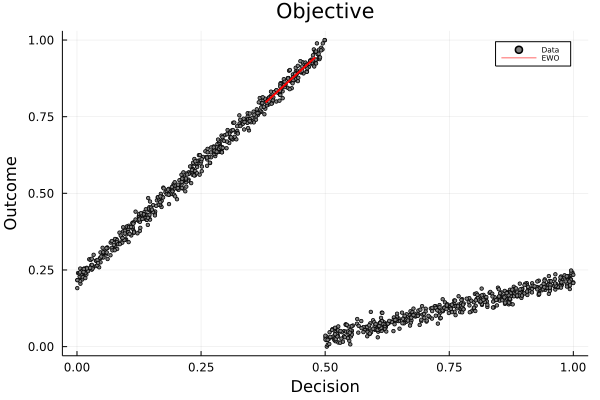

In [20]:
#Initializing results table
Results = Array{Union{Missing, String, Int64, Float64}}(missing, 3*seed_numbers, 11+6)    #创建一个空数组。为啥有四种变量？？？？？？

seed_number = 1   ### 一个是seed_number, 一个是seed_numbers
#Running models for specified number of seeds to generate results
#for seed_number = 1:seed_numbers
	println()   #空行，显得更美观
	println("seed_number: ", seed_number)

	#Initializing parameter settings in results table
	Results[3*(seed_number-1)+1,1:11] = [form_data,alpha,beta,gamma,rho,sigma,kappa,lambda,n,m,seed_number]   
	Results[3*(seed_number-1)+2,1:11] = [form_data,alpha,beta,gamma,rho,sigma,kappa,lambda,n,m,seed_number]
	Results[3*(seed_number-1)+3,1:11] = [form_data,alpha,beta,gamma,rho,sigma,kappa,lambda,n,m,seed_number]

	#Generating data
	x_data,y_data,y_min_data,y_max_data,d_data = Data(n,m,alpha,beta,gamma,rho,sigma,form_data,seed_number)

	#Solving Estimate-While-Optimize model
	solution_EWO = EWO(x_data,y_data,d_data,kappa,lambda,big_M)

	#Saving solution and plotting parameters for Estimate-While-Optimize model
	a_EWO = solution_EWO[3]
	b_EWO = solution_EWO[4]
	z_EWO = solution_EWO[5]
	x_EWO = dot(d_data,z_EWO)
	y_EWO = Result(y_min_data,y_max_data,x_EWO,alpha,beta,gamma,rho,form_data)
	x_EWO_range = collect(x_EWO - kappa:(2*kappa/100):x_EWO + kappa)
	y_EWO_range = a_EWO*ones(length(x_EWO_range)) + b_EWO*x_EWO_range

	#Writing Estimate-While-Optimize results to results table
	Results[3*(seed_number-1)+1,12:17] = ["EWO",a_EWO,b_EWO,0,x_EWO[1],y_EWO[1]]

	#Printing Estimate-While-Optimize results
	println("EWO")
	println("a: ", a_EWO)
	println("b: ", b_EWO)
	println("x: ", x_EWO)
	println("y: ", y_EWO)


#Writing results table to text file
writedlm("Results2.txt", Results)
### If wanna plot, delete for and end, make the seed_number a fixed number
	
#Plotting data   Why cannot plot here?Because our seed number is changing at first, so the software does not know how to draw it 
gr()
p = plot(x_data,y_data,seriestype=:scatter,title="Objective",xlabel="Decision",ylabel="Outcome",label="Data",legendfontsize=5,markersize=2,markercolor="grey")
p = plot!(x_EWO_range,y_EWO_range,label="EWO",linewidth=2,linecolor="red")      ###Why sometimes plot, sometimes plot!??????
plot(p)

In [21]:
Data(n,m,alpha,beta,gamma,rho,sigma,form_data,seed_number)

([0.23603334566204692, 0.34651701419196046, 0.3127069683360675, 0.00790928339056074, 0.4886128300795012, 0.21096820215853596, 0.951916339835734, 0.9999046588986136, 0.25166218303197185, 0.9866663668987996  …  0.39156063077532455, 0.08647581116899206, 0.2471400232044878, 0.8868062745871368, 0.2919050948006141, 0.5199583544162651, 0.1679341393063234, 0.6413444341641539, 0.5920390405970326, 0.7305275173488932], [0.5968930659598222, 0.7053328563194812, 0.6761013964423183, 0.22625027099921266, 0.9377455306670224, 0.5396662933067169, 0.20474602359527164, 0.20948319026336396, 0.5873545880567164, 0.2054232154169199  …  0.8136379720999016, 0.33420552121026326, 0.5609247919242804, 0.16632020437452635, 0.6336497481871937, 0.06142569737642474, 0.4898219636824664, 0.08705463868115336, 0.1131784623618185, 0.12816942806403112], 85.60199867410817, 151.52836764733624, [0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19  …  0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9])

将实验数据分成五折进行交叉验证 K-Fold 交叉验证 (Cross-Validation)

In [22]:
x_data

1000-element Vector{Float64}:
 0.23603334566204692
 0.34651701419196046
 0.3127069683360675
 0.00790928339056074
 0.4886128300795012
 0.21096820215853596
 0.951916339835734
 0.9999046588986136
 0.25166218303197185
 0.9866663668987996
 0.5557510873245723
 0.43710797460962514
 0.42471785049513144
 ⋮
 0.6107828421580266
 0.5201317258703348
 0.39156063077532455
 0.08647581116899206
 0.2471400232044878
 0.8868062745871368
 0.2919050948006141
 0.5199583544162651
 0.1679341393063234
 0.6413444341641539
 0.5920390405970326
 0.7305275173488932

In [23]:
x_train = x_data[1:800]
x_train2 = append!(x_data[1:600],x_data[801:1000])   #使用append!实现向量拼接
x_train3 = append!(x_data[1:400],x_data[601:1000])
x_train4 = append!(x_data[1:200],x_data[401:1000])
x_train5 = x_data[201:1000]

800-element Vector{Float64}:
 0.4771885892298522
 0.6375726156430861
 0.7371788786228548
 0.5519005128586842
 0.9234976566470738
 0.8128536217742204
 0.185426424532527
 0.20538807932853897
 0.08814371884969696
 0.6744533301782865
 0.33794220187492874
 0.8801892582399489
 0.4314597241256688
 ⋮
 0.6107828421580266
 0.5201317258703348
 0.39156063077532455
 0.08647581116899206
 0.2471400232044878
 0.8868062745871368
 0.2919050948006141
 0.5199583544162651
 0.1679341393063234
 0.6413444341641539
 0.5920390405970326
 0.7305275173488932

In [24]:
x_test = x_data[801:1000]
x_test2 = x_data[601:800]
x_test3 = x_data[401:600]
x_test4 = x_data[201:400]
x_test5 = x_data[1:200]

200-element Vector{Float64}:
 0.23603334566204692
 0.34651701419196046
 0.3127069683360675
 0.00790928339056074
 0.4886128300795012
 0.21096820215853596
 0.951916339835734
 0.9999046588986136
 0.25166218303197185
 0.9866663668987996
 0.5557510873245723
 0.43710797460962514
 0.42471785049513144
 ⋮
 0.9319243650736815
 0.8665652258833973
 0.6282341905766105
 0.48766682865498767
 0.9275209597696863
 0.1498122904503374
 0.6122962039695901
 0.7760943915820184
 0.36400338991488757
 0.287311121363512
 0.25866238457932944
 0.5303955035772412

In [25]:
y_data

1000-element Vector{Float64}:
 0.5968930659598222
 0.7053328563194812
 0.6761013964423183
 0.22625027099921266
 0.9377455306670224
 0.5396662933067169
 0.20474602359527164
 0.20948319026336396
 0.5873545880567164
 0.2054232154169199
 0.06861501618578787
 0.8731322571859736
 0.8756852149223817
 ⋮
 0.07689624176519884
 0.040337278010731885
 0.8136379720999016
 0.33420552121026326
 0.5609247919242804
 0.16632020437452635
 0.6336497481871937
 0.06142569737642474
 0.4898219636824664
 0.08705463868115336
 0.1131784623618185
 0.12816942806403112

In [26]:
y_train = y_data[1:800]
y_train2 = append!(y_data[1:600],y_data[801:1000])
y_train3 = append!(y_data[1:400],y_data[601:1000])
y_train4 = append!(y_data[1:200],y_data[401:1000])
y_train5 = y_data[201:1000]

800-element Vector{Float64}:
 0.9694347830927093
 0.0505436033140051
 0.11540956440419506
 0.032917001197199376
 0.19400776511931625
 0.1535171917890267
 0.46493204441726615
 0.5250311094477917
 0.36234659767464383
 0.09783688964063411
 0.740545865116504
 0.1640577332363937
 0.864667383911305
 ⋮
 0.07689624176519884
 0.040337278010731885
 0.8136379720999016
 0.33420552121026326
 0.5609247919242804
 0.16632020437452635
 0.6336497481871937
 0.06142569737642474
 0.4898219636824664
 0.08705463868115336
 0.1131784623618185
 0.12816942806403112

In [27]:
y_test = y_data[801:1000]
y_test2 = y_data[601:800]
y_test3 = y_data[401:600]
y_test4 = y_data[201:400]
y_test5 = y_data[1:200]

200-element Vector{Float64}:
 0.5968930659598222
 0.7053328563194812
 0.6761013964423183
 0.22625027099921266
 0.9377455306670224
 0.5396662933067169
 0.20474602359527164
 0.20948319026336396
 0.5873545880567164
 0.2054232154169199
 0.06861501618578787
 0.8731322571859736
 0.8756852149223817
 ⋮
 0.18598946316265957
 0.15554593492800775
 0.07675352281595037
 0.9442055567729234
 0.1942027345153818
 0.4424726505728981
 0.07908833166466757
 0.11178865355828427
 0.7686039901956233
 0.664101083575342
 0.6369568723213883
 0.012655009374679727

问题：如何在julia里面实现交叉验证？

Since the numerical results in 5 groups are close, we can conclude that our model is solid.

分成五折进行交叉验证，并计算每一折交叉验证中training set中的x^*.

In [39]:
num = 0 #记录循环次数
y_optimal = []   #存放y的最优值
for lambda = 0.1:0.1:1
    for kappa = 0.01:0.01:0.1   #上次在原来基础上加了两个循环
        
    x = []   #存放每一次的最优x值
    x_optimal = []

    #Initializing results table
    Results = Array{Union{Missing, String, Int64, Float64}}(missing, 3*seed_numbers, 11+6)    #创建一个空数组。为啥有四种变量？？？？？？

    seed_number = 1   ### 一个是seed_number, 一个是seed_numbers
    train_data = 800
    test_data = 200
#Running models for specified number of seeds to generate results
#for seed_number = 1:seed_numbers
	println()   #空行，显得更美观
	println("seed_number: ", seed_number)



	#Solving Estimate-While-Optimize model
	solution_EWO = EWO(x_train,y_train,d_data,kappa,lambda,big_M)
    solution_EWO2 = EWO(x_train2,y_train2,d_data,kappa,lambda,big_M)
    solution_EWO3 = EWO(x_train3,y_train3,d_data,kappa,lambda,big_M)
    solution_EWO4 = EWO(x_train4,y_train4,d_data,kappa,lambda,big_M)
    solution_EWO5 = EWO(x_train5,y_train5,d_data,kappa,lambda,big_M)

	#Saving solution and plotting parameters for Estimate-While-Optimize model
	a_EWO1 = solution_EWO[3] 
	b_EWO1 = solution_EWO[4] 
	z_EWO1 = solution_EWO[5] 
	x_EWO1 = dot(d_data,z_EWO)
	y_EWO1 = Result(y_min_data,y_max_data,x_EWO1,alpha,beta,gamma,rho,form_data)
    x = push!(x,x_EWO1)

    a_EWO2 = solution_EWO2[3] 
	b_EWO2 = solution_EWO2[4] 
	z_EWO2 = solution_EWO2[5] 
	x_EWO2 = dot(d_data,z_EWO2)
	y_EWO2 = Result(y_min_data,y_max_data,x_EWO2,alpha,beta,gamma,rho,form_data)
    x = push!(x,x_EWO2)

    a_EWO3 = solution_EWO3[3] 
	b_EWO3 = solution_EWO3[4] 
	z_EWO3 = solution_EWO3[5] 
	x_EWO3 = dot(d_data,z_EWO3)
	y_EWO3 = Result(y_min_data,y_max_data,x_EWO3,alpha,beta,gamma,rho,form_data)
    x = push!(x,x_EWO3)

    a_EWO4 = solution_EWO4[3] 
	b_EWO4 = solution_EWO4[4] 
	z_EWO4 = solution_EWO4[5] 
	x_EWO4 = dot(d_data,z_EWO4)
	y_EWO4 = Result(y_min_data,y_max_data,x_EWO4,alpha,beta,gamma,rho,form_data)
    x = push!(x,x_EWO4)

    a_EWO5 = solution_EWO5[3] 
	b_EWO5 = solution_EWO5[4] 
	z_EWO5 = solution_EWO5[5] 
	x_EWO5 = dot(d_data,z_EWO5)
	y_EWO5 = Result(y_min_data,y_max_data,x_EWO5,alpha,beta,gamma,rho,form_data)
    x = push!(x,x_EWO5)
        
    

	#Writing Estimate-While-Optimize results to results table
	Results[3*(seed_number-1)+1,12:17] = ["EWO",a_EWO,b_EWO,0,x_EWO[1],y_EWO[1]]

	#Printing Estimate-While-Optimize results
	println("EWO1")
	println("a: ", a_EWO1)
	println("b: ", b_EWO1)
	println("x: ", x_EWO1)
	println("y: ", y_EWO1)
    println()

	println("EWO2")
	println("a: ", a_EWO2)
	println("b: ", b_EWO2)
	println("x: ", x_EWO2)
	println("y: ", y_EWO2)
    println()

	println("EWO3")
	println("a: ", a_EWO3)
	println("b: ", b_EWO3)
	println("x: ", x_EWO3)
	println("y: ", y_EWO3)
    println()

	println("EWO4")
	println("a: ", a_EWO4)
	println("b: ", b_EWO4)
	println("x: ", x_EWO4)
	println("y: ", y_EWO4)
    println()

	println("EWO5")
	println("a: ", a_EWO5)
	println("b: ", b_EWO5)
	println("x: ", x_EWO5)
	println("y: ", y_EWO5)
        

    seed_number = 1   ### 一个是seed_number, 一个是seed_numbers
    x_optimal = x   #x的最优值向量
    x_points = []
    y_points = []
    index = 0 # 用于记录x_test的序号
    #Running models for specified number of seeds to generate results
    #for seed_number = 1:seed_numbers

    for i in x_test
        index = index + 1
        if abs(i-x_optimal[1]) <= kappa
            x_points = push!(x_points,i)
            y_points = push!(y_points,y_test[index])
        end
    end

    y_average1 = mean(y_points)
    println(y_average1)
    index = 0
    x_points = []
    y_points = []


    for i in x_test2
        index = index + 1
        if abs(i-x_optimal[2]) <= kappa
            x_points = push!(x_points,i)
            y_points = push!(y_points,y_test2[index])
        end
    end

    y_average2 = mean(y_points)
    println(y_average2)
    index = 0
    x_points = []
    y_points = []

    
    for i in x_test3
        index = index + 1
        if abs(i-x_optimal[3]) <= kappa
            x_points = push!(x_points,i)
            y_points = push!(y_points,y_test3[index])
        end
    end

    y_average3 = mean(y_points)
    println(y_average3)
    index = 0
    x_points = []
    y_points = []


    for i in x_test4
        index = index + 1
        if abs(i-x_optimal[4]) <= kappa
            x_points = push!(x_points,i)
            y_points = push!(y_points,y_test4[index])
        end
    end

    y_average4 = mean(y_points)
    println(y_average4)
    index = 0
    x_points = []
    y_points = []


    for i in x_test5
        index = index + 1
        if abs(i-x_optimal[5]) <= kappa
            x_points = push!(x_points,i)
            y_points = push!(y_points,y_test5[index])
        end
    end

    y_average5 = mean(y_points)
    println(y_average5)
    index = 0
    x_points = []
    y_points = []
        
    yoptimal = (y_average1+y_average2+y_average3+y_average4+y_average5)/5
    y_optimal = push!(y_optimal,yoptimal)   #存放y最优质的的向量
    num = num + 1

    println("The numer of iteration: " ,num)
    println("The optimal average value is:")  
    println(yoptimal)
        
    end
end
    
println(y_optimal)

#Writing results table to text file
#writedlm("Results2.txt", Results)
### If wanna plot, delete for and end, make the seed_number a fixed number
	
#Plotting data   Why cannot plot here?Because our seed number is changing at first, so the software does not know how to draw it 
#gr()
#p = plot(x_train,y_train,seriestype=:scatter,title="Objective",xlabel="Decision",ylabel="Outcome",label="Data",legendfontsize=5,markersize=2,markercolor="grey")
#p = plot!(x_EWO_range,y_EWO_range,label="EWO",linewidth=2,linecolor="red")      ###Why sometimes plot, sometimes plot!??????
#plot(p)


seed_number: 1
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
EWO1
a: 1000.0
b: 0.0
x: 0.43
y: 0.8706379893180601

EWO2
a: 999.5290525838084
b: 0.6633062199734687
x: 0.71
y: 0.10842401056236764

EWO3
a: 999.7470602865781
b: 0.44375388319630243
x: 0.57
y: 0.0553344797037622

EWO4
a: 1000.0514055252365
b: -0.09018513199391652
x: 0.57
y: 0.0553344797037622

EWO5
a: 999.9999999997744
b: 4.661661612281875e-10
x: 0.57
y: 0.0553344797037622
0.8810567112713077
0.10770335330088332
0.059594470020530005
0.08259350228354796
0.04560482579025353
The numer of iteration: 1
The optimal average value is:
0.2353105725333045

seed_number: 1
Academic license - for non-commercial use only - expires 2022-08-28
Academic 

seed_number: 1
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
EWO1
a: 0.21359623942385314
b: 1.5268194995597115
x: 0.43
y: 0.8706379893180601

EWO2
a: 0.21867144754290455
b: 1.5176934642529427
x: 0.4
y: 0.8251326771535412

EWO3
a: 0.22513914525029424
b: 1.502672625254904
x: 0.4
y: 0.8251326771535412

EWO4
a: 0.21857621052249182
b: 1.5179582452882991
x: 0.4
y: 0.8251326771535412

EWO5
a: 0.2092460544152634
b: 1.539174846249327
x: 0.4
y: 0.8251326771535412
0.7480209992311256
0.8340551354732969
0.8213797326952443
0.8053355745614136
0.8370576292974063
The numer of iteration: 10
The optimal average value is:
0.8091698142516973

seed_number: 1
Academic license - for non-commercial use only - expires 2022

seed_number: 1
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
EWO1
a: 0.21359623942385367
b: 1.5268194995597095
x: 0.43
y: 0.8706379893180601

EWO2
a: 0.2217367480110115
b: 1.5091712170416427
x: 0.41
y: 0.8403011145417142

EWO3
a: 0.22121529071670498
b: 1.5106209894272387
x: 0.41
y: 0.8403011145417142

EWO4
a: 0.21867144754290424
b: 1.5176934642529434
x: 0.41
y: 0.8403011145417142

EWO5
a: 0.21824680216880124
b: 1.518551985503432
x: 0.41
y: 0.8403011145417142
0.7888700641036753
0.8406519105090288
0.8428917236107183
0.8183676200810637
0.850021869923678
The numer of iteration: 19
The optimal average value is:
0.828160637645633

seed_number: 1
Academic license - for non-commercial use only - expires 2

seed_number: 1
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
EWO1
a: 0.20300676000567996
b: 1.5493633421160449
x: 0.43
y: 0.8706379893180601

EWO2
a: 0.21360912250714748
b: 1.5264753570449021
x: 0.42
y: 0.8554695519298872

EWO3
a: 0.20004621465966266
b: 1.5576488737613619
x: 0.42
y: 0.8554695519298872

EWO4
a: 0.2182468014819534
b: 1.5185519854931044
x: 0.42
y: 0.8554695519298872

EWO5
a: 0.19598340013049179
b: 1.5661380907016194
x: 0.42
y: 0.8554695519298872
0.8156429423101637
0.8498530386447265
0.8624846239388464
0.8315918264001407
0.862673260119541
The numer of iteration: 28
The optimal average value is:
0.8444491382826836

seed_number: 1
Academic license - for non-commercial use only - expires

seed_number: 1
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
EWO1
a: 0.23054417573342414
b: 1.4833326055170313
x: 0.43
y: 0.8706379893180601

EWO2
a: 0.21191244258079084
b: 1.5313583944417877
x: 0.43
y: 0.8706379893180601

EWO3
a: 0.20897633949001482
b: 1.5374242828795313
x: 0.43
y: 0.8706379893180601

EWO4
a: 0.22311346522178976
b: 1.5065170739522808
x: 0.4
y: 0.8251326771535412

EWO5
a: 0.20749539541314296
b: 1.5408237268650957
x: 0.43
y: 0.8706379893180601
0.8690051701047244
0.8767789790385251
0.8765992515510193
0.8071586453078012
0.8758869379125152
The numer of iteration: 37
The optimal average value is:
0.8610857967829171

seed_number: 1
Academic license - for non-commercial use only - expire

Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
EWO1
a: 0.20300676000567996
b: 1.5493633421160449
x: 0.43
y: 0.8706379893180601

EWO2
a: 0.22756306780863683
b: 1.4967666773105814
x: 0.44
y: 0.8858064267062331

EWO3
a: 0.22723077226329724
b: 1.4976153212222065
x: 0.44
y: 0.8858064267062331

EWO4
a: 0.23312419379367078
b: 1.4826179599173586
x: 0.41
y: 0.8403011145417142

EWO5
a: 0.19836857959798618
b: 1.561288972594207
x: 0.44
y: 0.8858064267062331
0.867548624165142
0.8830611645326122
0.894031154314122
0.8172459856924995
0.8939839270370229
The numer of iteration: 46
The optimal average value is:
0.8711741711482797

seed_number: 1
Academic license - for non-commercial use only - expires 2022-08-28
Acad

Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
EWO1
a: 0.22636814387683496
b: 1.4951105952759887
x: 0.43
y: 0.8706379893180601

EWO2
a: 0.2519005887428873
b: 1.436925253570938
x: 0.42
y: 0.8554695519298872

EWO3
a: 0.233124193793671
b: 1.4826179599173581
x: 0.43
y: 0.8706379893180601

EWO4
a: 0.2703660782215803
b: 1.3972161732403714
x: 0.43
y: 0.8706379893180601

EWO5
a: 0.23293907227647903
b: 1.4830369914195427
x: 0.43
y: 0.8706379893180601
0.8594526851719007
0.8599790979218855
0.8760616915425223
0.8586356093004489
0.88950853497198
The numer of iteration: 55
The optimal average value is:
0.8687275237817473

seed_number: 1
Academic license - for non-commercial use only - expires 2022-08-28
Academic

seed_number: 1
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
EWO1
a: 0.2067307718134056
b: 1.541834369789087
x: 0.43
y: 0.8706379893180601

EWO2
a: 0.22051382654263524
b: 1.509039943999356
x: 0.46
y: 0.916143301482579

EWO3
a: 0.2109050322546675
b: 1.5329121060447173
x: 0.46
y: 0.916143301482579

EWO4
a: 0.22022606631719938
b: 1.516170889816011
x: 0.42
y: 0.8554695519298872

EWO5
a: 0.19836857959798618
b: 1.561288972594207
x: 0.46
y: 0.916143301482579
0.8647631348889483
0.9017754653203963
0.9302127670800469
0.8378683632383525
0.911573432936
The numer of iteration: 64
The optimal average value is:
0.8892386326927488

seed_number: 1
Academic license - for non-commercial use only - expires 2022-08-28

seed_number: 1
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
EWO1
a: 0.2810802867249757
b: 1.3718987086207164
x: 0.43
y: 0.8706379893180601

EWO2
a: 0.23848177754325578
b: 1.4735201729271097
x: 0.47
y: 0.931311738870752

EWO3
a: 0.21090503225466606
b: 1.5329121060447206
x: 0.47
y: 0.931311738870752

EWO4
a: 0.21553844505063996
b: 1.5240275712077755
x: 0.47
y: 0.931311738870752

EWO5
a: 0.19836857960388252
b: 1.5612889725857286
x: 0.47
y: 0.931311738870752
0.8708061469977615
0.926287047323135
0.9349552953187986
0.9329493104817459
0.9203174243761538
The numer of iteration: 73
The optimal average value is:
0.9170630448995191

seed_number: 1
Academic license - for non-commercial use only - expires 202

Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
EWO1
a: 0.19211730506800082
b: 1.576123477556555
x: 0.43
y: 0.8706379893180601

EWO2
a: 0.21741101725337542
b: 1.5110932937099728
x: 0.45
y: 0.9009748640944061

EWO3
a: 0.11077908839981225
b: 1.7403997431023706
x: 0.48
y: 0.946480176258925

EWO4
a: 0.35331500196863774
b: 1.2175696186237381
x: 0.46
y: 0.916143301482579

EWO5
a: 0.28774093057238476
b: 1.3627272325140094
x: 0.46
y: 0.916143301482579
0.8773702455010909
0.8868903564530227
0.9436582520160014
0.9224307732475683
0.9171392521694124
The numer of iteration: 82
The optimal average value is:
0.909497775877419

seed_number: 1
Academic license - for non-commercial use only - expires 2022-08-28
Academ

Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
EWO1
a: -0.24867194354647534
b: 2.486719435465019
x: 0.43
y: 0.8706379893180601

EWO2
a: -0.2469067271491999
b: 2.4690672716582034
x: 0.49
y: 0.961648613647098

EWO3
a: -0.2480941856150556
b: 2.4809418561525183
x: 0.49
y: 0.961648613647098

EWO4
a: 0.4442727797010893
b: 1.0232388038867812
x: 0.47
y: 0.931311738870752

EWO5
a: 0.4620370865383003
b: 0.9852854555649547
x: 0.46
y: 0.916143301482579
0.8810567112713077
0.96413836084505
0.9704013710934207
0.9365127820333103
0.9105503455569104
The numer of iteration: 91
The optimal average value is:
0.9325319141599998

seed_number: 1
Academic license - for non-commercial use only - expires 2022-08-28
Academic 

seed_number: 1
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
Academic license - for non-commercial use only - expires 2022-08-28
EWO1
a: 0.21073229638969626
b: 1.5326002703886252
x: 0.43
y: 0.8706379893180601

EWO2
a: 0.2136091225071474
b: 1.5264753570449017
x: 0.4
y: 0.8251326771535412

EWO3
a: 0.22250546355981682
b: 1.5066539690678826
x: 0.4
y: 0.8251326771535412

EWO4
a: 0.2084739512438474
b: 1.5388044575155007
x: 0.4
y: 0.8251326771535412

EWO5
a: 0.20239288551091203
b: 1.5521797616417325
x: 0.4
y: 0.8251326771535412
0.7480209992311256
0.8340551354732969
0.8213797326952443
0.8053355745614136
0.8370576292974063
The numer of iteration: 100
The optimal average value is:
0.8091698142516973
Any[0.2353105725333045, 0.9285470492090878, 0.9170630448995191, 0.903385603

将training set中找到的x^*分别代入五折交叉验证中得测试集，计算得到y^*.然后求y^*的平均值。

In [50]:
number = 0
num = 0   #最大元素的序号 record the position of the largest value
x = []
y = []
optimalv = []
bestv = 0
for lambda = 0.1:0.1:1
    for kappa = 0.01:0.01:0.1
        number = number + 1
        valuey = y_optimal[number]
        if valuey > bestv
            bestv = valuey
            num = number
        end
        optimalv = push!(optimalv,valuey)
        x = push!(x,lambda)
        y = push!(y,kappa)
    end
end

plot(x,y,optimalv,st=:surface,camera=(-30,30))   #Draw the picture of the EWO function
println("The largest number is:",num," th")
println("The maximal value of y is:", maximum(optimalv))

The largest number is:21 th
The maximal value of y is:0.9431635280993884


In [1]:
1+2

3